# Modeling

Gradient boost regression tree (GBRT) is chosen for its high level of interpreability and relative easy of training.


In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import sparse
from sklearn import ensemble
import pickle
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib
from IPython.display import HTML
import helpers

## Grid Search

In [12]:
# runtime parameter
grid_search = False

In [13]:
# Part of the rationale behind the train test split is inspired by this post: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

X = pd.DataFrame(sparse.load_npz("../data/X.npz").toarray())
y = pd.read_csv("../data/y.csv", index_col=0, header=None)
var_names = pickle.load(open('../data/var_names.pkl', 'rb'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

for dataset, name in [(X_train, "X_train"), (X_test, "X_test"), (y_train, "y_train"), (y_test, "y_test")]:
        dataset.to_csv("../data/train_test_data/" + name + ".csv")

y_train = y_train.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

params = {'n_estimators': [500], 'max_depth': range(4, 15, 4), 'min_samples_split': range(2, 1003, 400), 
          'min_samples_leaf':range(30,71,20), 'max_features': ["sqrt", "log2", None], 'subsample':[0.7,0.75,0.8,0.85],
            }

rgs = ensemble.GradientBoostingRegressor(learning_rate=0.01, loss='ls', warm_start=True)


Warning: the following cell could take a while (around 2 hours in my case) to run
I could search for the best parameters in groups, but here I chose to search all together to keep the code simple and short 

In [14]:
if grid_search:
    g_search = GridSearchCV(estimator=rgs, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-2, iid=False, cv=3, verbose=10)
    g_search.fit(X_train, y_train)
    joblib.dump(g_search, open('../models/g_search.pkl', 'wb'))
else:
    g_search = joblib.load(open('../models/g_search.pkl', 'rb'))

In [15]:
print(g_search.best_params_)
print(g_search.best_score_)

{'max_depth': 12, 'max_features': None, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}
-0.11925073438404503


In [16]:
rgs = g_search.best_estimator_
rgs.fit(X_train, y_train)

c:\users\zack\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
c:\users\zack\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=None, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=12, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=30, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=True)

In [17]:
mse = mean_squared_error(y_test, rgs.predict(X_test))
print("Final MSE: %.4f" % mse)

Final MSE: 0.1143


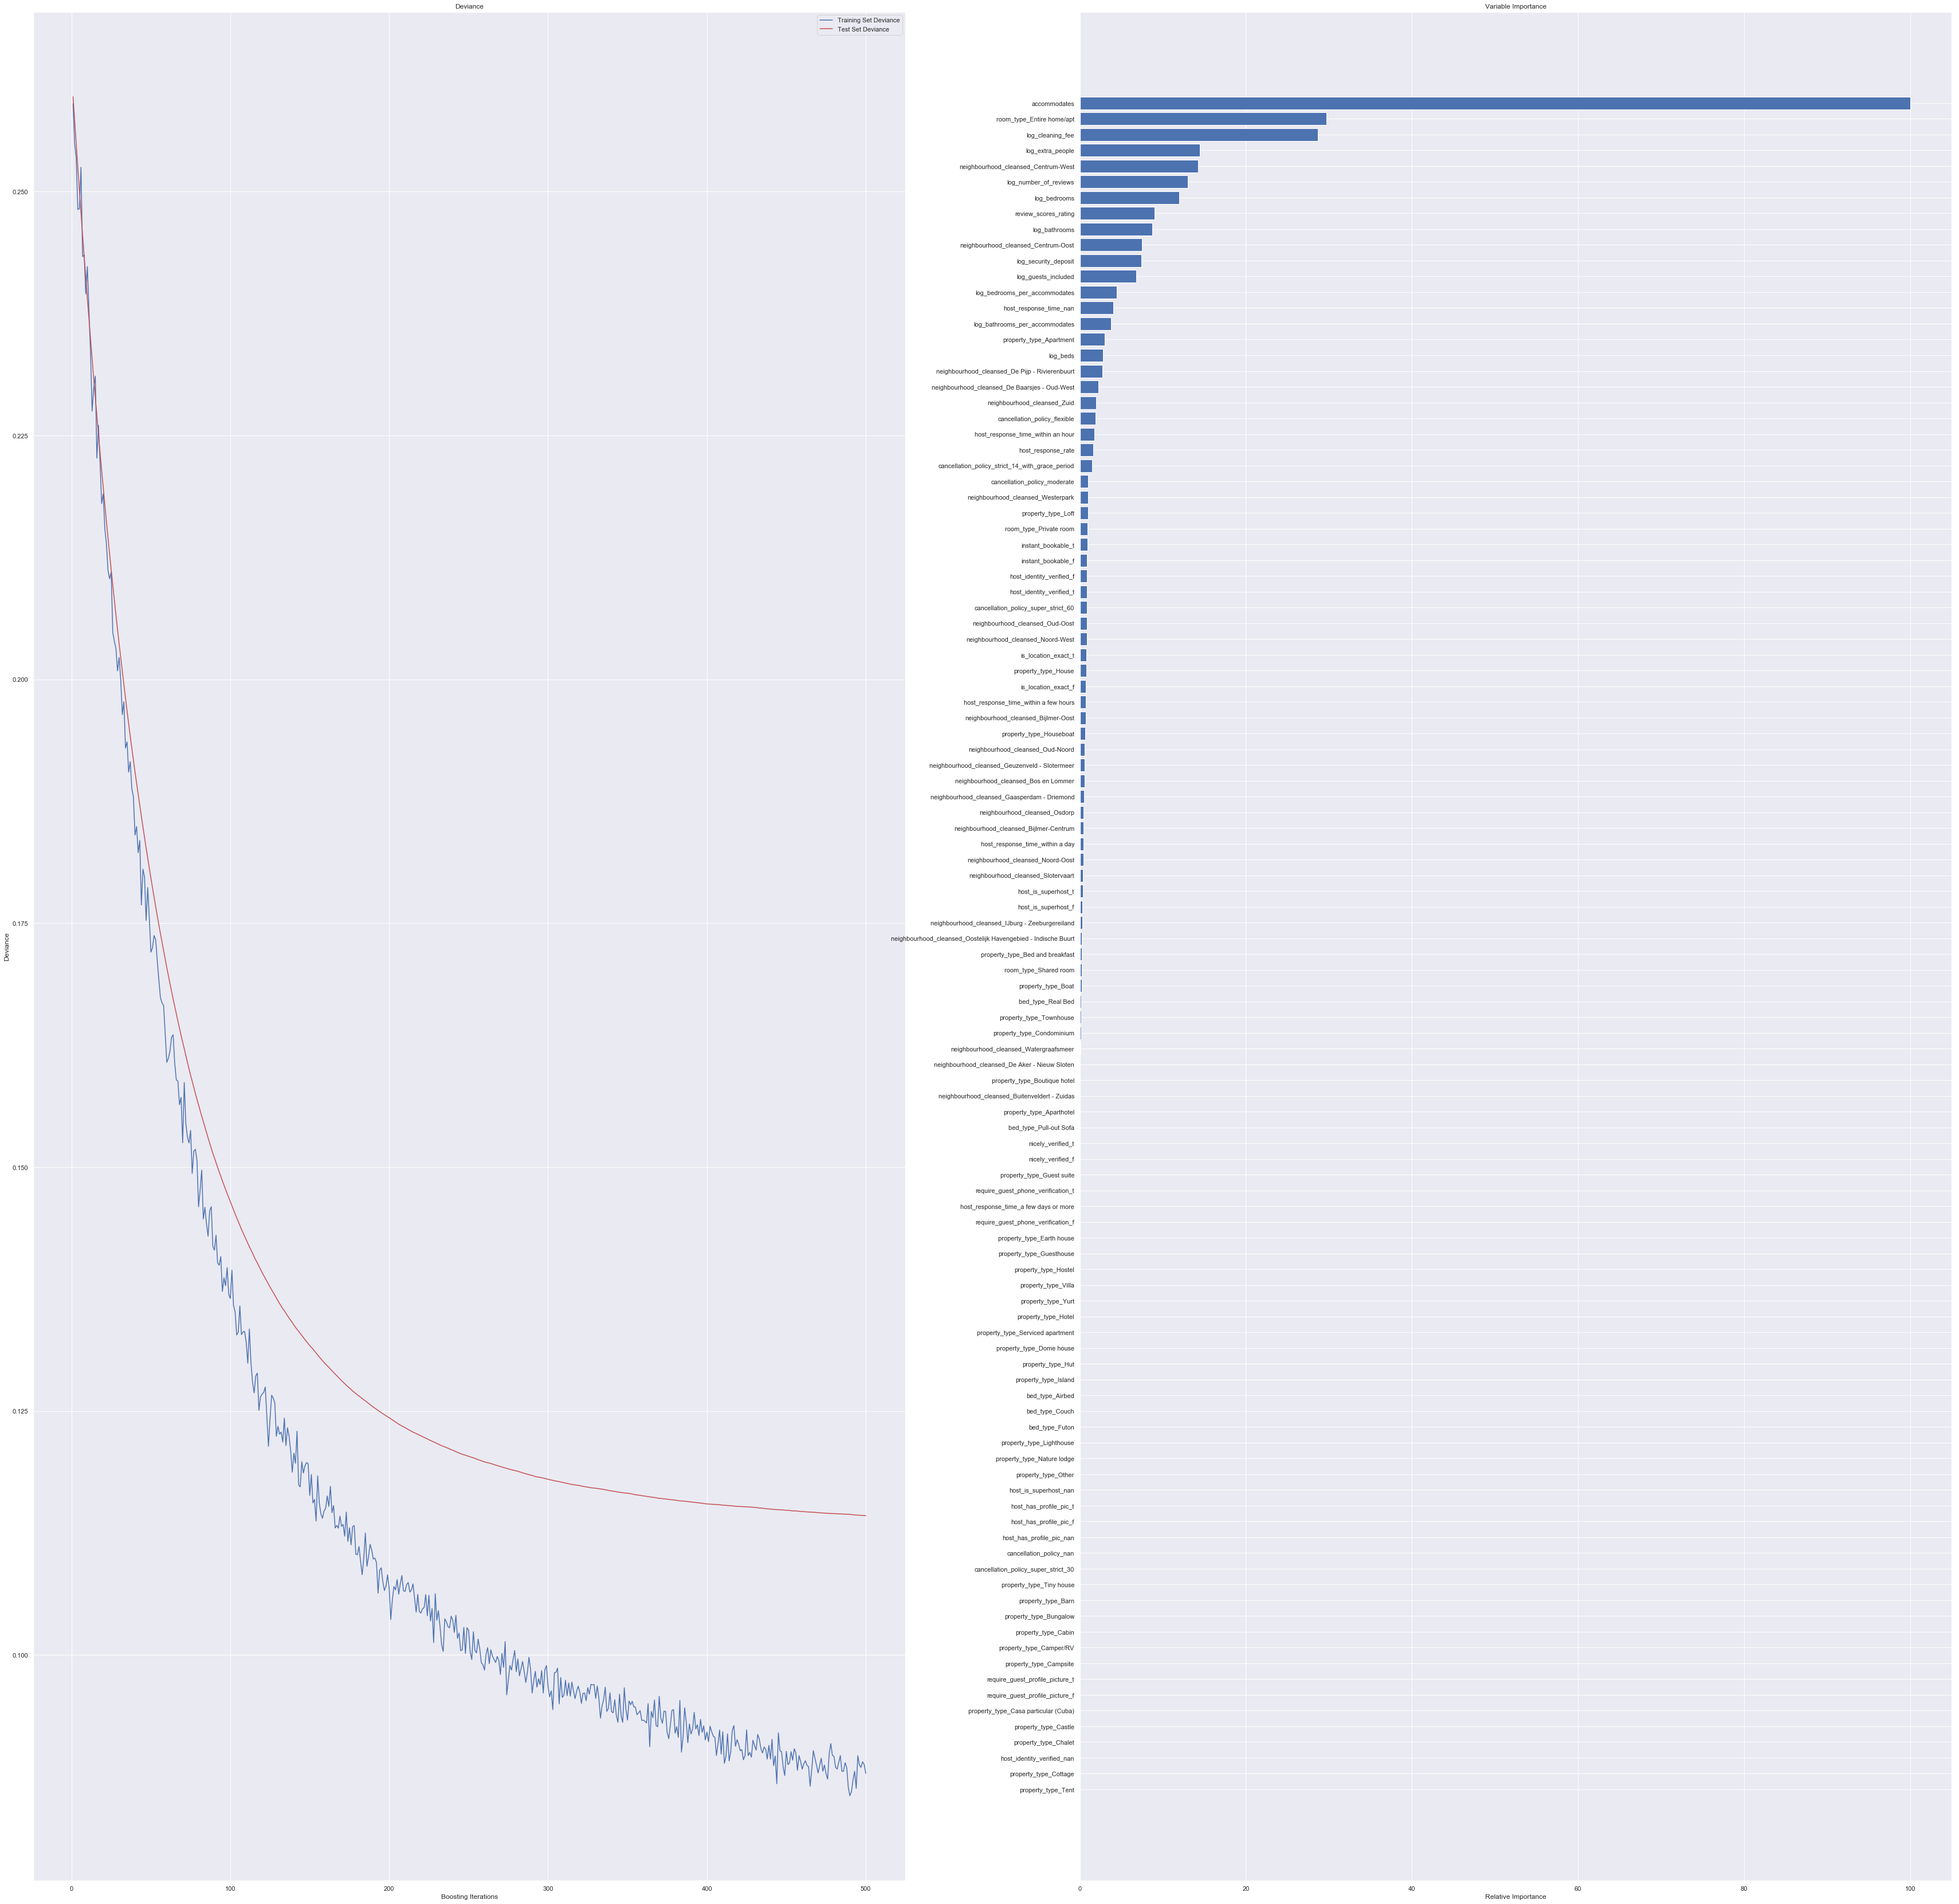

In [18]:
# Plot training deviance

n_estimators = g_search.best_params_['n_estimators']
# compute test set deviance
test_score = np.zeros((n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(rgs.staged_predict(X_test)):
    test_score[i] = rgs.loss_(y_test, y_pred)

plt.figure(figsize=(60, 60))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(n_estimators) + 1, rgs.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance

feature_importance = rgs.feature_importances_
# make importance relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
ranked_features_asc = np.array(var_names)[sorted_idx]
plt.yticks(pos, ranked_features_asc)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('../imgs/deviance.png')

Check out [the saved plot](../imgs/deviance.png) to see the actual texts.

We can see that as we increase the number of estimators for the tree, the errors decrease. Thus, we would increase the amount of estimators for better performance.

We can also take a look at the learning curve to examine the bias and variance of our model.

Warning: the cell below could take a while

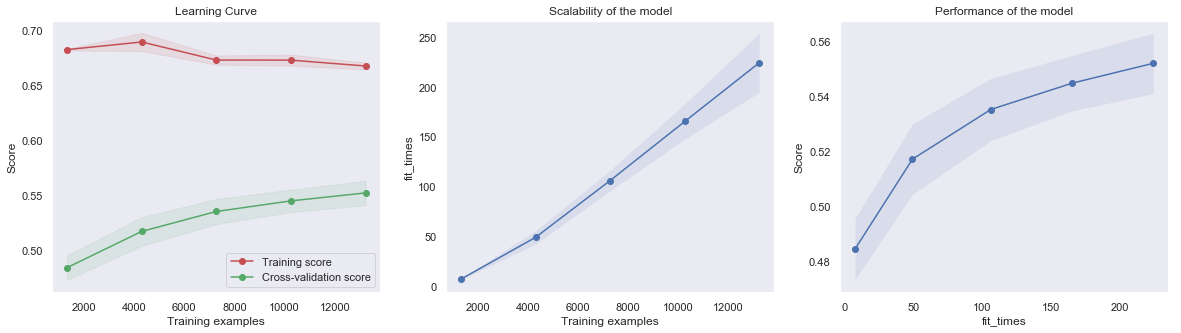

In [25]:
from sklearn.model_selection import learning_curve

# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
params = g_search.best_params_
params["learning_rate"] = .01
params["loss"] = 'ls'
params["warm_start"] = True

train_scores_mean = helpers.plot_learning_curve(ensemble.GradientBoostingRegressor(**params), "Learning Curve", X_train, y_train, n_jobs=-1) 
plt.show()

Now we can further classify the variables by their importance.

In [20]:
ranked_features_dsc = ranked_features_asc[::-1]
print("Features of most importance (descending):\n")
# rank the features in descending order
higher_cutoff_idx = np.argmax(feature_importance[sorted_idx]>=5)
lower_cutoff_idx = np.argmax(feature_importance[sorted_idx]>=1)

second_level_idx = (len(feature_importance) - higher_cutoff_idx + 1) * ["More Important (>=5)"] + (higher_cutoff_idx - lower_cutoff_idx) * ["Less Important (1<= && <5)"] + \
                     (lower_cutoff_idx - 1) * ["Not Important (<1)"]
feature_df = pd.DataFrame(feature_importance[sorted_idx][::-1], index=[second_level_idx, ranked_features_dsc], columns=["Importance"])

HTML(feature_df.to_html())

Features of most importance (descending):



In [21]:
results = sm.OLS(y_pred,sm.add_constant(y_test)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     5369.
Date:                Sat, 28 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:07:35   Log-Likelihood:                -57.018
No. Observations:                4136   AIC:                             118.0
Df Residuals:                    4134   BIC:                             130.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2385      0.037     60.814      0.0

The intercept (called "constant" in the table) is and the slope (x1 in the table) seem to be heavily influenced by the outliers.  
The R-squared value is .565, meaning the variables used in training could explain 56.5% of the variation in the log price. 
P values for both the intercept and the slope for are 0, meaning they are statistically significant. 

We can also draw a scatter plot of our predictions against the true prices in the test dataset and draw a fit.

c:\users\zack\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


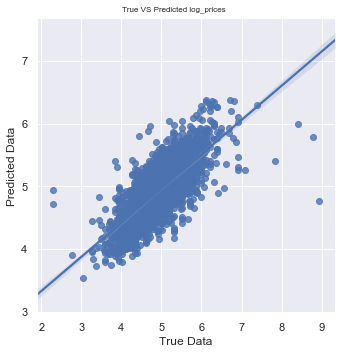

In [22]:
sns_plot = sns.lmplot(x="True Data", y='Predicted Data', data=pd.DataFrame(list(zip(y_test, y_pred)), columns =['True Data', 'Predicted Data']), fit_reg=True)
fig = sns_plot.fig
fig.suptitle('True VS Predicted log_prices', fontsize=8)
fig.savefig('../imgs/true_vs_predicted_log_prices.png')
plt.show()

The plot looks great with residual relatively evenly distributed around the fitted line, with a very limited number of outliers. 

# Future Improvement

1. 
Some variables are not used in this challenge. Most notably, the text-based variables such as "description," "neighborhood_overview", and "transit" would likely to have a great amount of impact on the prices.
A direction for future improvement could be to convert them into numerical variables by taking the average pooling of the word vectors.

2.
We could also try different models other than GBRT.
